## NCAA Win Predictor Using Kenpom 

This program uses college basketball stats from kenpom to determine winners of selected matchups using machine learning

In [1]:
import kenpompy
import kenpompy.summary as kp
import kenpompy.team as kpt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import re, os, warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


## Using Kenpompy to gather data. 

For this first section, you will need to have a valid paid kenpom account. I do not have access to such an account at the moment so I could not verify that this section of the code is still functional. Fortunatley, the original stats that I used when building this project are stored in the 'Stats_CSVs' folder, which I will be using from here on out. 

In [2]:
from kenpompy.utils import login

def setup_kenpompy_browser():
    """
    Sets up the KenPom browser session using credentials from environment variables.

    Note: This function will fail to run without valid KenPom credentials.
    """
    try:
        # Retrieve KenPom credentials from environment variables
        username = os.getenv('KENPOM_USERNAME')
        password = os.getenv('KENPOM_PASSWORD')

        # Ensure that both username and password are provided
        if not username or not password:
            raise ValueError("KenPom credentials are missing.")

        # Attempt to log in to KenPom using the provided credentials
        browser = login(username, password)
    
    except Exception as e:
        # Handle any errors that occur during the login process
        print("Please enter valid KenPom credentials to set up the browser")
        return None
    
    return browser


# NOTE: commented code below will only work with valid kenpom account
# Fetching current season's stats from kenpompy:

# browser = setup_kenpompy_browser()

# eff_stats = kp.get_efficiency(browser)
# four_factors = kp.get_fourfactors(browser)
# team_stats = kp.get_teamstats(browser)
# point_dist = kp.get_pointdist(browser)
# heights = kp.get_height(browser)
# player_stats = kp.get_playerstats(browser)
# valid_teams = kpt.get_valid_teams(browser)

## Inputting data from the "Stats_CSVs" folder

In [3]:
eff_stats = pd.read_csv('./Stats_CSVs/eff_stats.csv')
four_factors = pd.read_csv('./Stats_CSVs/four_factors.csv')
team_stats = pd.read_csv('./Stats_CSVs/team_stats.csv')
point_dist = pd.read_csv('./Stats_CSVs/point_dist.csv')

# valid_teams would typically be imported from Kenpom
# What I've done here is taken the valid_teams list retroactivley from the data
# This skips the step of needed to have a paid kenpom account
valid_teams=pd.read_csv('./Stats_CSVs/full_stats.csv')['Team']

## Cleaning the data

In [4]:
# Function to remove columns matching specific patterns
def remove_unwanted_columns(df):
    # Remove columns that contain 'Rank', 'Raw', 'Conference', or 'Unnamed: 0'
    return df[df.columns.drop(df.filter(regex='Rank|Raw|Conference|Unnamed: 0').columns)]

# Apply the function to each DataFrame
eff_stats = remove_unwanted_columns(eff_stats)
four_factors = remove_unwanted_columns(four_factors)
team_stats = remove_unwanted_columns(team_stats)
point_dist = remove_unwanted_columns(point_dist)

In [5]:
# Function to remove all of the teams that are not in valid_teams
def remove_low_rank_teams(df):
    df = df[df['Team'].isin(valid_teams)]
    df = df.sort_values(by="Team")
    return df

eff_stats = remove_low_rank_teams(eff_stats)
four_factors = remove_low_rank_teams(four_factors)
team_stats = remove_low_rank_teams(team_stats)
point_dist = remove_low_rank_teams(point_dist)

Creating a dataset of all valid teams' stats

In [6]:
from functools import reduce

# List of DataFrames to merge
dfs = [eff_stats, four_factors, team_stats, point_dist]

# Merging all DataFrames on "Team" using reduce
full_stats = reduce(lambda left, right: pd.merge(left, right, on="Team"), dfs)

full_stats.to_csv("./Stats_CSVs/full_stats.csv")

full_stats

,Team,Tempo-Adj,Avg. Poss Length-Offense,Avg. Poss Length-Defense,Off. Efficiency-Adj,Def. Efficiency-Adj,AdjTempo,AdjOE_x,Off-eFG%,Off-TO%,...,Stl%,A%,3PA%,AdjOE_y,Off-FT,Off-2P,Off-3P,Def-FT,Def-2P,Def-3P
0,Abilene Christian,69.9,16.6,17.2,102.9,99.4,69.9,102.9,47.8,17.5,...,7.2,10.4,56.7,36.2,23.0,49.6,27.4,25.6,44.8,29.6
1,Air Force,63.1,20.3,17.3,95.9,103.9,63.1,95.9,50.9,21.5,...,8.5,13.0,57.7,43.5,14.6,48.9,36.4,22.3,54.2,23.5
2,Akron,62.0,19.1,18.3,106.1,102.6,62.0,106.1,52.8,17.8,...,8.4,9.5,49.0,41.7,20.8,45.8,33.4,15.7,52.9,31.4
3,Alabama,71.7,15.5,17.4,116.1,98.7,71.7,116.1,51.5,19.8,...,10.5,9.3,52.9,48.0,19.2,46.0,34.8,20.2,51.0,28.8
4,Alabama A&M,66.4,17.8,17.3,87.6,101.0,66.4,87.6,41.3,19.6,...,10.8,8.7,43.4,24.9,22.5,58.5,19.0,17.5,49.3,33.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,Wright St.,68.4,16.8,17.8,106.5,107.1,68.4,106.5,52.0,17.9,...,10.7,7.2,50.7,32.5,18.6,56.2,25.2,15.3,56.1,28.6
354,Wyoming,66.0,18.7,17.6,109.6,97.1,66.0,109.6,52.3,17.0,...,7.7,9.3,43.4,41.8,20.4,48.2,31.4,16.0,53.3,30.7
355,Xavier,68.3,16.6,18.1,110.3,97.9,68.3,110.3,50.2,16.5,...,9.5,7.0,55.8,35.9,20.0,52.4,27.7,16.4,53.1,30.5
356,Yale,68.7,17.6,16.4,101.3,99.1,68.7,101.3,50.1,18.4,...,10.3,8.2,46.5,36.3,19.4,51.8,28.8,17.8,50.6,31.6


## The clean_schedules() function
This function processes and cleans the game schedule data for a specified team. It retrieves the schedule using the kpt package, filters and formats the data to include only relevant opponents and results, and then merges the team's stats with those of their opponents. The final output is a DataFrame containing detailed game statistics, including the team's scores, opponent scores, and the game result in a binary format (1 for win, 0 for loss).

Note:
This function is currently non-functional without access to the kenpompy package, which requires a valid, paid KenPom account for operation. The kpt.get_schedule function relies on this package to fetch team schedules, making it essential for the function to work. Without a KenPom account, this function cannot retrieve the necessary schedule data. Since this project was originally created with a valid kenpom account, the data that clean_schedules() would generate is in the "full_season_full_stats.csv" file within "Stats_CSVs"

In [7]:
# Function to clean and process the schedule of a given team
def clean_schedules(data, team_name):
    # Retrieve the schedule for the specified team using the provided browser instance
    # NOTE: browser will not work without a valid kenpom account
    schedule = kpt.get_schedule(browser, team_name)
    
    # Rename the "Opponent Name" column to "Opponent" for clarity
    schedule.rename(columns={"Opponent Name": "Opponent"}, inplace=True)
    
    # Filter and clean the schedule data
    schedule = schedule.drop(columns='Date')  # Drop the "Date" column as it's not needed
    schedule = schedule[schedule['Opponent'].isin(valid_teams)]  # Keep rows where opponents are in the valid teams list
    schedule = schedule[schedule['Result'].str.len() < 11]  # Filter out invalid results
    schedule = schedule[schedule['Result'] != 'Result']  # Remove any rows where the "Result" column contains the header
    
    schedule = schedule.reset_index(drop=True)  # Reset the index for the cleaned DataFrame
    
    full_results = schedule['Result']

    # If the first result is detailed (e.g., not just "W" or "L"), split it into components
    if len(full_results[0]) > 3:
        results, team_scores, opp_scores = [], [], []
        for i in range(len(full_results)):
            clean_result = re.sub(r"\s", "", full_results[i])  # Remove any whitespace
            clean_result = re.split(r"[-,]", clean_result)  # Split the result string into its components
            results.append(clean_result[0])
            team_scores.append(clean_result[1])
            opp_scores.append(clean_result[2])
    
    # Extract the main team stats from the 'data' DataFrame
    main_team_stats = data[data['Team'] == team_name]
    final_df = pd.DataFrame()

    # Create a DataFrame with the main team's stats repeated for each opponent
    for _ in schedule['Opponent']:
        final_df = final_df.append(main_team_stats)
    
    # Create a DataFrame for the opponents' stats
    opp_df = pd.DataFrame()
    for opponent in schedule['Opponent']:
        if opponent in valid_teams:
            opp_df = opp_df.append(data[data['Team'] == opponent])
    
    # Reset indices for both DataFrames to prepare for merging
    final_df.to_csv('./Stats_CSVs/clean_schedules_1.csv', index=False)
    final_df = pd.read_csv('./Stats_CSVs/clean_schedules_1.csv')
    opp_df.to_csv('./Stats_CSVs/clean_schedules_2.csv', index=False)
    opp_df = pd.read_csv('./Stats_CSVs/clean_schedules_2.csv')
    
    # Prefix opponent columns with "opp_" to avoid conflicts during merging
    opp_df = opp_df.add_prefix('opp_')
    
    # Merge the team stats with opponent stats
    final_df = pd.concat([final_df, opp_df], axis=1)
    
    # Remove unnecessary columns after merging
    final_df.drop(columns=['opp_Unnamed: 0', 'Unnamed: 0', 'opp_Team', 'Team'], inplace=True)
    
    # Add team and opponent scores to the final DataFrame
    final_df['team_score'] = team_scores
    final_df['opp_score'] = opp_scores
    
    # Convert result strings to binary values (1 for win, 0 for loss)
    final_df['Result'] = [1 if result == 'W' else 0 for result in results]
    
    return final_df

In [8]:
def create_complete_season_df(browser):
    season_df = pd.DataFrame()

    for team in valid_teams:
        try:
            team_data = clean_schedules(team, full_stats, browser)
            season_df = season_df.append(team_data)
        except (IndexError) as e:
            print("Error processing ", team, e)
            continue

    season_df.to_csv("./Stats_CSVs/full_season_full_stats.csv")
    
    return season_df
    
# NOTE: This next line will throw an error
browser = setup_kenpompy_browser()

# NOTE: This function will not work without a valid browser
# create_complete_season_df(browser)

Please enter valid KenPom credentials to set up the browser


## Building and training the decision tree model:

Reading stats from preloaded CSV

In [9]:
season_df = pd.read_csv("./Stats_CSVs/full_season_full_stats.csv")
season_df = season_df.drop(columns='Unnamed: 0')
season_df

,Tempo-Adj,Avg. Poss Length-Offense,Avg. Poss Length-Defense,Off. Efficiency-Adj,Def. Efficiency-Adj,AdjTempo,AdjOE_x,Off-eFG%,Off-TO%,Off-OR%,...,opp_AdjOE_y,opp_Off-FT,opp_Off-2P,opp_Off-3P,opp_Def-FT,opp_Def-2P,opp_Def-3P,team_score,opp_score,Result
0,72.5,14.5,17.8,121.8,88.8,72.5,121.8,59.4,15.9,29.0,...,37.3,20.1,51.5,28.4,17.6,52.9,29.5,97,63,1
1,72.5,14.5,17.8,121.8,88.8,72.5,121.8,59.4,15.9,29.0,...,36.0,19.5,52.4,28.1,20.9,51.9,27.2,86,74,1
2,72.5,14.5,17.8,121.8,88.8,72.5,121.8,59.4,15.9,29.0,...,29.5,20.0,55.7,24.3,20.1,50.7,29.2,84,57,1
3,72.5,14.5,17.8,121.8,88.8,72.5,121.8,59.4,15.9,29.0,...,41.9,13.4,51.8,34.9,16.3,45.6,38.0,92,50,1
4,72.5,14.5,17.8,121.8,88.8,72.5,121.8,59.4,15.9,29.0,...,40.1,18.1,46.7,35.2,19.3,47.0,33.7,107,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10586,62.3,20.0,17.7,79.5,111.1,62.3,79.5,42.4,26.1,30.0,...,31.8,17.4,57.1,25.5,16.4,52.4,31.2,66,56,1
10587,62.3,20.0,17.7,79.5,111.1,62.3,79.5,42.4,26.1,30.0,...,38.7,18.0,49.9,32.1,17.3,52.1,30.6,74,61,0
10588,62.3,20.0,17.7,79.5,111.1,62.3,79.5,42.4,26.1,30.0,...,34.7,17.4,53.8,28.8,19.1,45.1,35.8,66,54,0
10589,62.3,20.0,17.7,79.5,111.1,62.3,79.5,42.4,26.1,30.0,...,34.4,19.7,55.3,25.0,18.7,53.6,27.8,67,41,0


Creating and training the Decsision Tree Regressor model:

In [10]:
def evaluate_decision_tree_regressor(season_df):
    """
    Evaluates a DecisionTreeRegressor model by providing various metrics and visualizations.

    Parameters:
    - season_df: DataFrame containing the features and target variable.
    """
    # Prepare data
    X = season_df.drop(['Result', 'team_score', 'opp_score'], axis=1)
    y = season_df['Result']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)
    
    # Initialize and train the model
    model = tree.DecisionTreeRegressor(random_state=60)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = np.round(predictions, 2)  # Rounding predictions for clarity
    
    # Evaluate the model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'Training R^2 Score: {train_score:.2f}')
    print(f'Test R^2 Score: {test_score:.2f}')
    
    # Confusion Matrix is not applicable for regression; Skipping confusion matrix

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        print("Feature Importances:")
        print(importance_df.head(3))  # Print top 3 features
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f'Cross-Validation R^2 Scores: {cv_scores}')
    print(f'Average Cross-Validation R^2 Score: {cv_scores.mean():.2f}')

# Example usage
evaluate_decision_tree_regressor(season_df)


Training R^2 Score: 0.80
Test R^2 Score: -0.28
Feature Importances:
                    Feature  Importance
34  opp_Def. Efficiency-Adj    0.103810
6                   AdjOE_x    0.099185
36              opp_AdjOE_x    0.075250
Cross-Validation R^2 Scores: [-0.70459245 -0.40133369 -0.40283157 -0.40865477 -0.88322916]
Average Cross-Validation R^2 Score: -0.56


Accuracy: 0.67
Confusion Matrix:


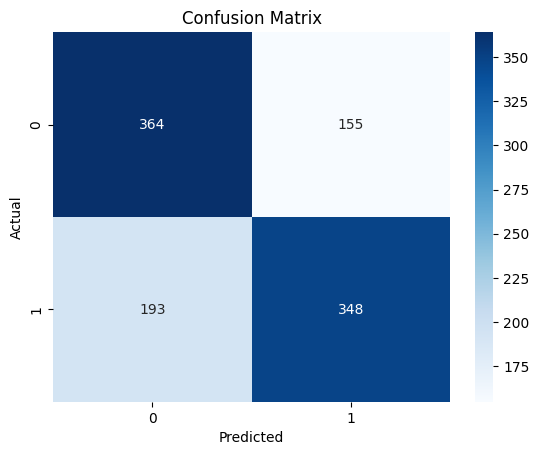

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       519
           1       0.69      0.64      0.67       541

    accuracy                           0.67      1060
   macro avg       0.67      0.67      0.67      1060
weighted avg       0.67      0.67      0.67      1060

Cross-Validation Accuracy: 0.34 ± 0.13
Top 3 Most Important Features:
        Feature  Importance
6       AdjOE_x    0.103291
11        AdjDE    0.093824
36  opp_AdjOE_x    0.092913


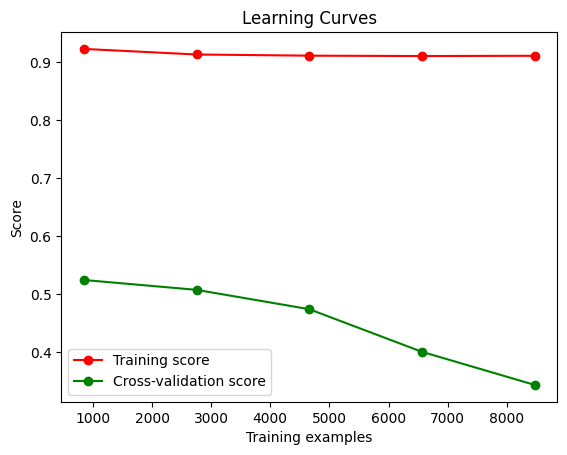

In [11]:
def evaluate_decision_tree_classifier(model, X, y, cv_folds=5, plot_learning_curves=True):
    """
    Evaluates a model by performing various checks to ensure it is not overfitting.
    
    Parameters:
    - model: A trained model (e.g., DecisionTreeClassifier, RandomForestClassifier).
    - X: Feature matrix (DataFrame or array).
    - y: Target variable (Series or array).
    - cv_folds: Number of folds for cross-validation.
    - plot_learning_curves: Boolean to plot learning curves.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=60)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)
    
    # Accuracy
    accuracy = model.score(X_test, y_test)
    print(f'Accuracy: {accuracy:.2f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, predictions))

    # Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')
    
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature_{i}' for i in range(X.shape[1])]
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        print("Top 3 Most Important Features:")
        print(importance_df.head(3))
    
    # Plot Learning Curves
    if plot_learning_curves:
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv_folds, scoring='accuracy')
        
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.legend(loc='best')
        plt.title('Learning Curves')
        plt.show()

# Initialize and train the Decision Tree model
X_ta = season_df.drop(['Result', 'team_score', 'opp_score'], axis=1)
y_ta = season_df['Result']
dt_classifier = DecisionTreeClassifier(random_state=42)
evaluate_decision_tree_classifier(dt_classifier, X_ta, y_ta)


## Predicting Individual Games with Decsion Tree:

In [12]:
def predict_game(team1, team2, full_stats=full_stats, model=dt_classifier):
    """
    Predicts the winner of a game between two teams based on their stats.

    Parameters:
    - team1: Name of the first team.
    - team2: Name of the second team.
    - full_stats: DataFrame containing stats for all teams.
    - model: Trained machine learning model used for prediction.

    Returns:
    - The name of the predicted winning team.
    """
    # Filter the stats for the two teams
    team1_df = full_stats.loc[full_stats['Team'] == team1].copy()
    team2_df = full_stats.loc[full_stats['Team'] == team2].copy()

    if team1_df.empty or team2_df.empty:
        raise ValueError("One or both teams not found in the dataset.")

    # Add prefix to opponent team columns
    team2_df = team2_df.add_prefix('opp_')

    # Add a temporary column for merging
    team1_df['join'] = 1
    team2_df['join'] = 1

    # Merge the two DataFrames on the 'join' column
    game_df = pd.merge(team1_df, team2_df, on='join')

    # Drop unnecessary columns
    columns_to_drop = ['Team', 'opp_Team', 'join']
    game_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Make prediction
    prediction = model.predict(game_df)

    # Determine the winner
    return team1 if prediction[0] > 0.5 else team2

## March Maddness Predictions:

In [13]:
first_four = [
    ['Wyoming', 'Indiana'],
    ['Bryant', 'Wright St.'],
    ['Texas Southern', 'Texas A&M Corpus Chris'],
    ['Rutgers', 'Notre Dame']
]

round_64 = [
    ['Gonzaga', 'Georgia St.'],
    ['Boise St.', 'Memphis'], 
    ['Connecticut', 'New Mexico St.'], 
    ['Arkansas', 'Vermont'],
    ['Alabama', predict_game('Rutgers', 'Notre Dame')],
    ['Texas Tech', 'Montana St.'],
    ['Michigan St.', 'Davidson'],
    ['Duke', 'Cal St. Fullerton'],
    ['Baylor', 'Norfolk St.'],
    ['North Carolina', 'Marquette'],
    ["Saint Mary's", predict_game('Wyoming', 'Indiana')],
    ['UCLA', 'Akron'],
    ['Texas', 'Virginia Tech'],
    ['Purdue', 'Yale'],
    ['Murray St.', 'San Francisco'],
    ['Kentucky', "Saint Peter's"],
    ['Arizona', predict_game('Bryant', 'Wright St.')],
    ['Seton Hall', 'TCU'],
    ['Houston', 'UAB'],
    ['Illinois', 'Chattanooga'],
    ['Colorado St.', 'Michigan'],
    ['Tennessee', 'Longwood'],
    ['Ohio St.', 'Loyola Chicago'],
    ['Villanova', 'Delaware'],
    ['Kansas', predict_game('Texas Southern', 'Texas A&M Corpus Chris')],
    ['San Diego St.', 'Creighton'],
    ['Iowa', 'Richmond'],
    ['Providence', 'South Dakota St.'],
    ['LSU', 'Iowa St.'],
    ['Wisconsin', 'Colgate'],
    ['USC', 'Miami FL'],
    ['Auburn', "Jacksonville St."]
]

By re-fitting the model in the next step, the network will return a differnt set of predictions:

In [14]:
preds_64 = []
preds_32 = []
preds_16 = []
preds_8 = []
preds_4 = []

for game in round_64:
    preds_64.append(predict_game(game[0], game[1]))

for i in range(0, len(preds_64), 2):
    preds_32.append(predict_game(preds_64[i],preds_64[i+1]))

for i in range(0, len(preds_32), 2):
    preds_16.append(predict_game(preds_32[i],preds_32[i+1]))

for i in range(0, len(preds_16), 2):
    preds_8.append(predict_game(preds_16[i],preds_16[i+1]))

for i in range(0, len(preds_8), 2):
    preds_4.append(predict_game(preds_8[i],preds_8[i+1]))

champion = predict_game(preds_4[0], preds_4[1])

print("Predicted Champion: ", champion)

Predicted Champion:  Connecticut


## Creating a deep learning model with Keras:

Test Loss: 0.5030
Test Accuracy: 0.7461
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


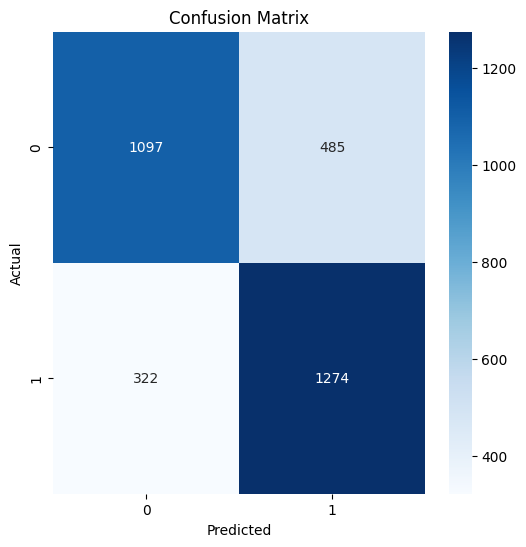

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1582
           1       0.72      0.80      0.76      1596

    accuracy                           0.75      3178
   macro avg       0.75      0.75      0.75      3178
weighted avg       0.75      0.75      0.75      3178



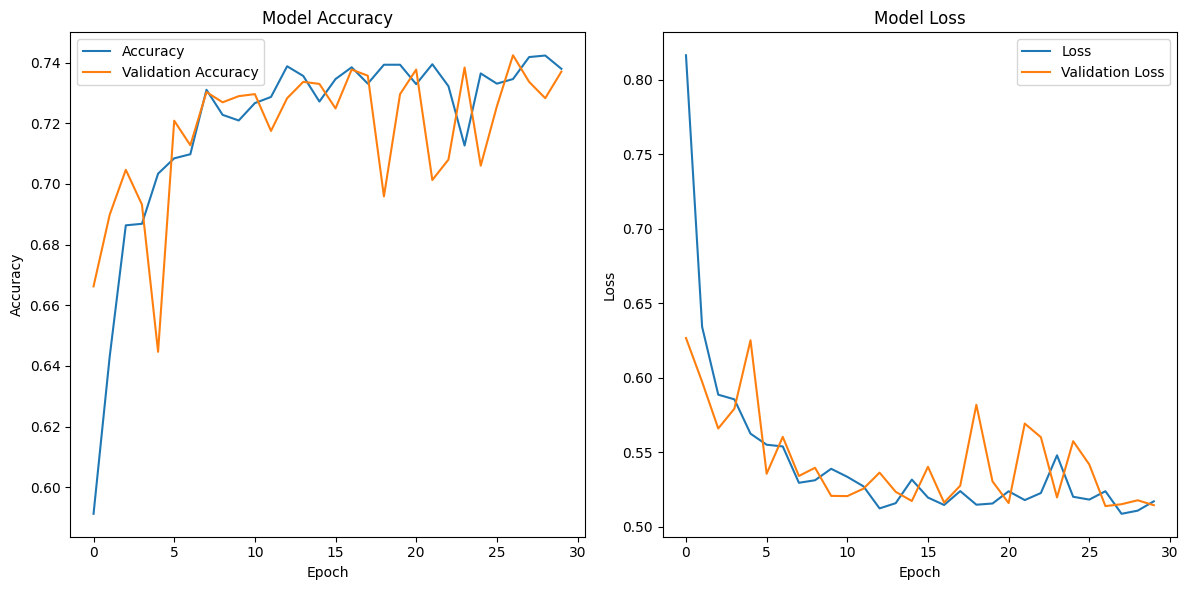

In [15]:
def evaluate_deep_learning_model(season_df, epochs=30, batch_size=50):
    """
    Evaluates a deep learning model on the given dataset.
    
    Parameters:
    - season_df: DataFrame containing the features and target variable.
    - epochs: Number of epochs for training.
    - batch_size: Batch size for training.
    """
    # Preparing data
    X = season_df.drop(['Result', 'team_score', 'opp_score'], axis=1).values
    y = season_df['Result'].values
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and compile the model
    def create_baseline():
        model = Sequential()
        model.add(Dense(60, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    model = create_baseline()

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Making predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model

# Example usage
deep_model = evaluate_deep_learning_model(season_df, epochs=30, batch_size=50)


## Functions used for predicting individual games based on trained model:

In [16]:
def get_matchup_data(team1, team2, full_stats):
    """
    Prepares matchup data for two teams and returns a combined DataFrame.
    
    Parameters:
    - team1: Name of the first team.
    - team2: Name of the second team.
    - full_stats: DataFrame containing the statistics for all teams.
    
    Returns:
    - DataFrame containing combined statistics of the two teams.
    """
    # Retrieve team stats
    team1_df = full_stats[full_stats['Team'] == team1].copy()
    team2_df = full_stats[full_stats['Team'] == team2].copy()

    # Add prefix to opponent's columns
    team2_df = team2_df.add_prefix('opp_')

    # Add a join column for merging
    team1_df['join'] = 1
    team2_df['join'] = 1

    # Merge dataframes
    game_df = pd.merge(team1_df, team2_df, on='join')

    # Drop unnecessary columns
    game_df.drop(['Team', 'opp_Team', 'join'], axis=1, inplace=True)

    return game_df

def dl_predict_game(team1, team2, deep_model=deep_model, full_stats=full_stats):
    """
    Predicts the winner of a game between two teams using the deep learning model.
    
    Parameters:
    - team1: Name of the first team.
    - team2: Name of the second team.
    - deep_model: The trained deep learning model.
    - full_stats: DataFrame containing the statistics for all teams.
    
    Returns:
    - The name of the predicted winning team.
    """
    # Prepare data
    game_data = get_matchup_data(team1, team2, full_stats).astype(float)
    
    # Make prediction
    prob = deep_model.predict(game_data)[0][0]
    
    # Print probability for debugging
    print(f"Prediction Probability: {prob:.2f}")
    
    # Return the predicted winner
    return team1 if prob > 0.5 else team2


## Making Predictions for the entire bracket:

In [17]:
preds_64 = []
preds_32 = []
preds_16 = []
preds_8 = []
preds_4 = []

for game in round_64:
    preds_64.append(dl_predict_game(game[0], game[1]))

for i in range(0, len(preds_64), 2):
    preds_32.append(dl_predict_game(preds_64[i],preds_64[i+1]))

for i in range(0, len(preds_32), 2):
    preds_16.append(dl_predict_game(preds_32[i],preds_32[i+1]))

for i in range(0, len(preds_16), 2):
    preds_8.append(dl_predict_game(preds_16[i],preds_16[i+1]))

for i in range(0, len(preds_8), 2):
    preds_4.append(dl_predict_game(preds_8[i],preds_8[i+1]))

champion = dl_predict_game(preds_4[0], preds_4[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Prediction Probability: 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction Probability: 0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Prediction Probability: 0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction Probability: 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction Probability: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Prediction Probability: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction Probability: 0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction Probability: 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction Probability: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction Probability: 0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction Probability: 0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction Probability: 0.89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction Probability: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prediction Probability: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prediction Probability: 0.51
1/1 ━━━━

## Final Prediction from the deep learning model:

In [18]:
print("Predicted Champion: ", champion)

Predicted Champion:  Gonzaga
